# Q1: Gibbs Sampling

Consider a data set on the heights of 695 women and 562 men.
Suppose we have the list of heights, but we don’t know which data
points are from women and which are from men. The data points are available [here](https://drive.google.com/file/d/1_sweLfvqtqdy6oRuAKAG9Le3H-LWaFVK/view?usp=sharing).
The combined distribution of all 1257 heights is shown below.

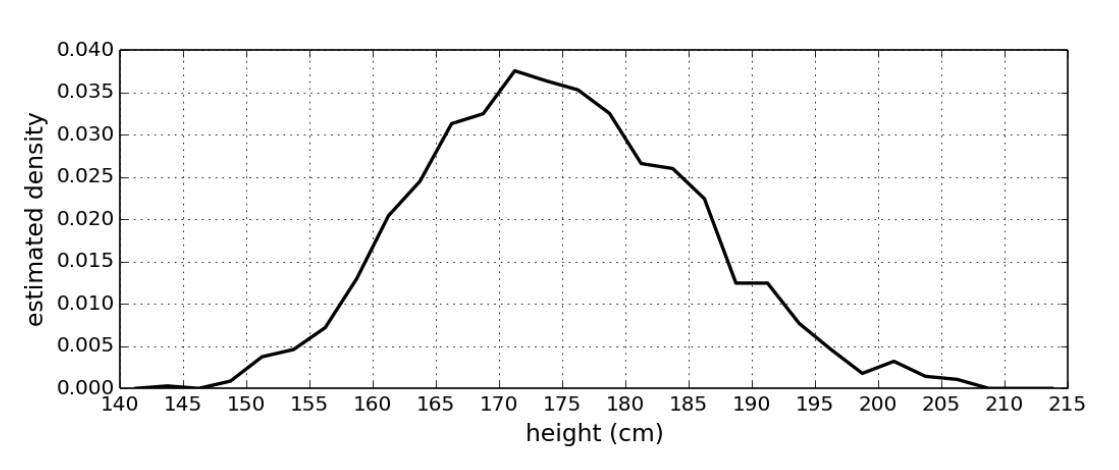

Consider that the combined height distribution is a two-component mixture of Normals, and there is an (essentially) unique set of mixture parameters
corresponding to each particular distribution.

To find individual distributions, let us consider a variable $Z_i$ that
indicates whether the subject i is female or male.
The mixture distribution can be specified as:

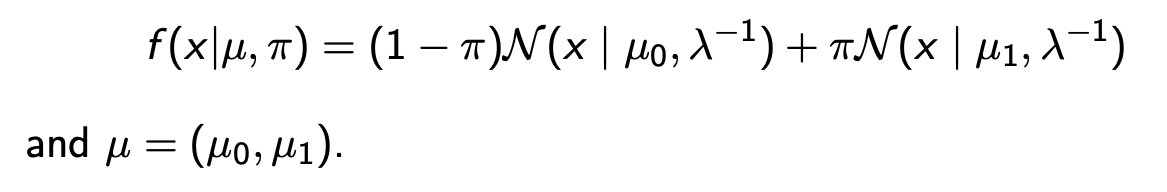

The full conditional distribution i.e. p($x_{1:n}$|µ, π) is a complicated function of µ and π, making the posterior difficult to sample from directly. Hence, we are going to use Gibbs sampling method to make our estimate for the individual components of the height gaussians.

The conditional distributions are specified as:

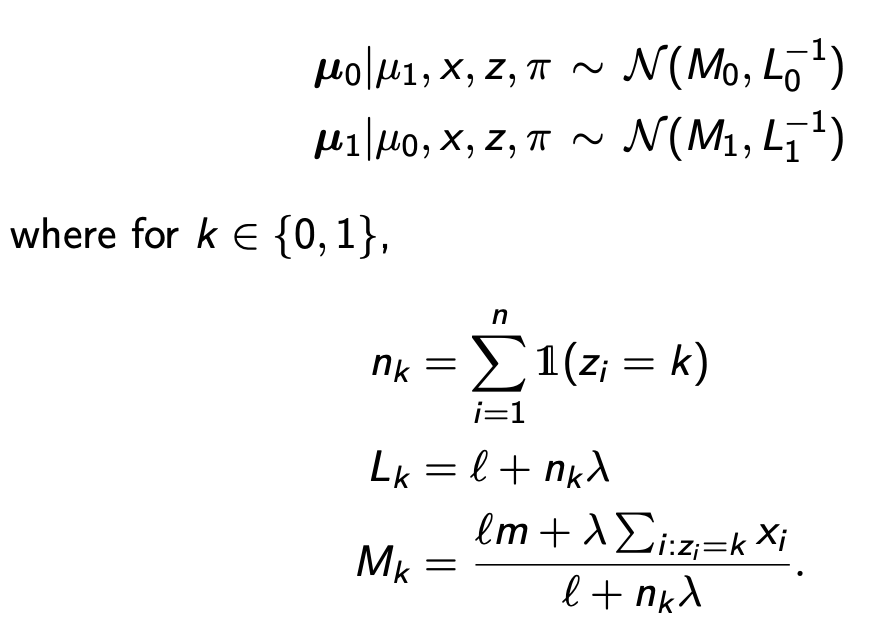

# $p(z|\mu, \pi, x)=$ 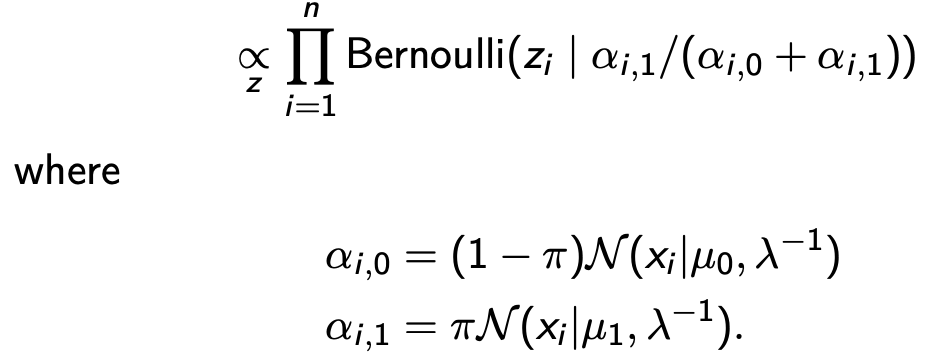

# $\pi = \frac{n_k}{n}$

The complete process can be specified as below:
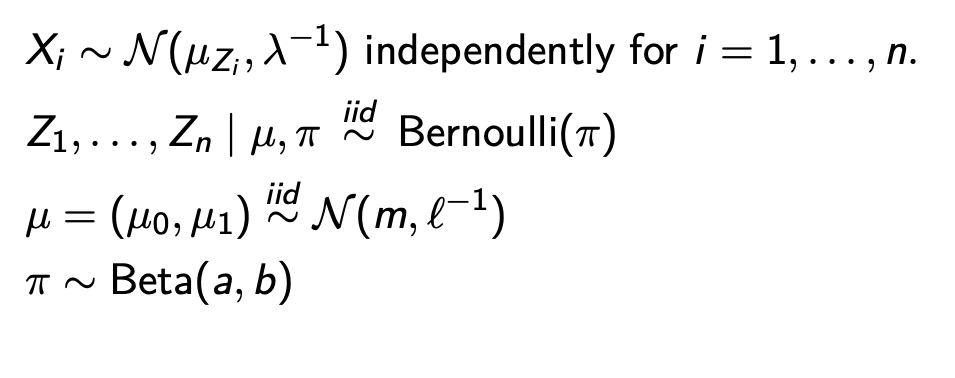

Consider the following initializations:

$\lambda = \frac{1}{\sigma^2}$ where $\sigma = 8$cm.

$m = 175 cm$

$l = \frac{1}{s^2}$ where $s = 15$cm.

a = 1, b = 1 (Beta parameters, equivalent to prior “sample
size” of 1 for each component)

$\pi = 0.5 $

$z_1, . . . , z_n$ are sampled i.i.d. from Bernoulli(1/2) (initial assignment
to components chosen uniformly at random)

$µ_0 = µ_1 = m$ (component means initialized to the mean of
their prior)

Q.1. Use a Gibbs Sampler given the conditionals and initializations provided above and plot the $µ_0, µ_1$ for 1000 samples. [10 marks]

Q.2. Plot the histograms of the heights of subjects assigned to each
component, according to $z_1, . . . , z_n$, in a typical sample after 1000 samples. [10 marks]

Q.3. Plot the $\pi$ for each iterations for both the components. [10 marks]

In [ ]:
import numpy as np
import typing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
# Data
data = """Height (in cm),Number of people
141,1
156,1
150,10
157,2
154,19
160,1
155,20
165,3
156,24
169,5
158,40
160,60
171,10
174,10
161,70
164,82
176,24
179,32
166,102
168,101
182,40
214,1
206,2
188,33
186,56
195,1
188,5
184,42
151,18
186,16
183,35
208,1
202,9
181,40
178,65
198,5
194,20
174,105
172,112
192,34
"""

In [ ]:
from io import StringIO

# The heights of all the individuals are given
# heights_prior = pd.read_csv("./Height.csv")
heights_prior = pd.read_csv(StringIO(data))
heights_list = []
for i in range(len(heights_prior)):
    for j in range(heights_prior["Number of people"][i]):
        heights_list.append(heights_prior["Height (in cm)"][i])

In [ ]:
# Standard deviation of the heights of individuals
sigma = 8
_lambda = 1 / (sigma**2)

# Standard deviation of the mean height of genders
s = 15
l = 1 / (s**2)

# Initial values for the mixing proportion of the two distributions
a = b = 1
pi = 0.5

# Male mean stands for mu_1 and female_mean stands for mu_0
m = 175
male_mean = female_mean = m

# n stands for the total number of people under consideration
men = 562
women = 695
n = 1257

In [ ]:
class State:
    """
    State class to store the current state of the Markov Chain

    :ivar val: The current value of the state
    :ivar dist: The distribution from which the value is sampled
    :ivar dist_args: The arguments of the distribution
    """

    __val: int
    __dist: typing.Callable
    __dist_args: typing.List[typing.Any]

    def __init__(self, dist, dist_args, val=None) -> None:
        self.__dist = dist
        self.__dist_args = dist_args
        if val != None:
            self.__val = val

    def sample(self, args=None) -> float | int:
        if args is None:
            self.__val = self.__dist(*self.__dist_args)
        else:
            self.__val = self.__dist(*args)
        return self.__val

    def get_val(self) -> float | int:
        assert self.__val != None, "Sample before asking for value"
        return self.__val

    def __str__(self) -> str:
        return str(self.__val)

    def __repr__(self) -> str:
        return str(self.__val)

    def __eq__(self, __value: object) -> bool:
        return self.__val == __value

In [ ]:
class BayesNet:
    """
    BayesNet class to store the Bayesian Network

    :ivar nodes: The nodes of the Bayesian Network
    :ivar adj_list: The adjacency list of the Bayesian Network in the form of a
                    dictionary where the keys are the nodes and the values are
                    the list of nodes to which the key node is connected.
    """

    __nodes: typing.List[State]
    __adj_list: typing.Dict[State, list[State]]

    def __init__(self, nodes, adj_list) -> None:
        self.__nodes = nodes
        self.__adj_list = adj_list

    def get_markov_blanket(self, node: State) -> list[State]:
        parents = []
        childrens_parents = []
        for key, value in self.__adj_list.items():
            if node in value:
                parents.append(key)
                continue
            for node in self.__adj_list[node]:
                if node in value:
                    childrens_parents.append(key)
                    break
        blanket = parents + childrens_parents + self.__adj_list[node]
        blanket = list(dict.fromkeys(blanket))
        return blanket

In [ ]:
def get_normal_pdf(
    x: float | int, mu: float | int, sigma: float | int
) -> float:
    """
    Function to get the probability density function of a normal distribution

    :param x: The value at which the probability density function is to be
              calculated
    :param mu: The mean of the normal distribution
    :param sigma: The standard deviation of the normal distribution
    :return: The probability density function of the normal distribution
    """
    return (1 / (sigma * np.sqrt((2 * np.pi)))) * np.exp(
        -0.5 * (x - mu) ** 2 / sigma**2
    )

In [ ]:
# Initial distributions for the heights of both genders
male_height_dist = State(
    np.random.default_rng().normal, [male_mean, _lambda**-1]
)
female_height_dist = State(
    np.random.default_rng().normal, [female_mean, _lambda**-1]
)

# Initial distributions for the means
female_mean = State(np.random.default_rng().normal, [m, l**-1], m)
male_mean = State(np.random.default_rng().normal, [m, l**-1], m)

# Distribution for pi (mixing value)
pi = State(np.random.default_rng().beta, [a, b], 0.5)

# The distributions for z_1, z_2, ..., z_n
z = []
for i in range(n):
    initial_value = np.random.default_rng().binomial(1, pi.get_val())
    z.append(State(np.random.default_rng().binomial, [1, pi], initial_value))

In [ ]:
print("Initial values of the parameters:")
print("pi =", pi.get_val())
print("female_mean =", female_mean.get_val())
print("male_mean =", male_mean.get_val())
print("Number of males =", z.count(1))
print("Number of females =", z.count(0))

Initial values of the parameters:
pi = 0.5
female_mean = 175
male_mean = 175
Number of males = 612
Number of females = 645


In [ ]:
number_of_iterations = 1000

mu_0_list = [175]
mu_1_list = [175]
pi_list = [0.5]

for i in range(number_of_iterations):
    # Sampling pi from the posterior distribution i.e. Beta(a + n_1, b + n_0)
    pi_val = pi.sample([a + z.count(1), b + n - z.count(1)])
    pi_list.append(pi_val)

    # Sampling z (z_1, z_2, ..., z_n) from the posterior distribution i.e.
    # Bernoulli(pi)
    for j in range(n):
        alpha_j_1 = pi.get_val() * get_normal_pdf(
            heights_list[j], male_mean.get_val(), np.sqrt(_lambda) ** -1
        )
        alpha_j_0 = (1 - pi.get_val()) * get_normal_pdf(
            heights_list[j], female_mean.get_val(), np.sqrt(_lambda) ** -1
        )
        z[j].sample([1, alpha_j_1 / (alpha_j_1 + alpha_j_0)])

    # Finding the parameters required for sampling mu_0 and mu_1 from their
    # posterior distributions
    number_of_males = z.count(1)
    number_of_females = n - number_of_males
    L_0 = l + number_of_females * _lambda
    L_1 = l + number_of_males * _lambda
    sum_of_female_heights = sum_of_male_heights = 0
    for j in range(n):
        if z[j] == 0:
            sum_of_female_heights += heights_list[j]
        else:
            sum_of_male_heights += heights_list[j]
    M_0 = (l * m + _lambda * sum_of_female_heights) / (
        l + number_of_females * _lambda
    )
    M_1 = (l * m + _lambda * sum_of_male_heights) / (
        l + number_of_males * _lambda
    )

    # Sampling mu_0 and mu_1 from the posterior distribution i.e. Normal(M_0, L_0)
    # and Normal(M_1, L_1) respectively
    mu_0 = female_mean.sample([M_0, np.sqrt(L_0) ** -1])
    mu_1 = male_mean.sample([M_1, np.sqrt(L_1) ** -1])

    mu_0_list.append(mu_0)
    mu_1_list.append(mu_1)

### Question 1.1 - Plotting the distribution of mu_0 and mu_1

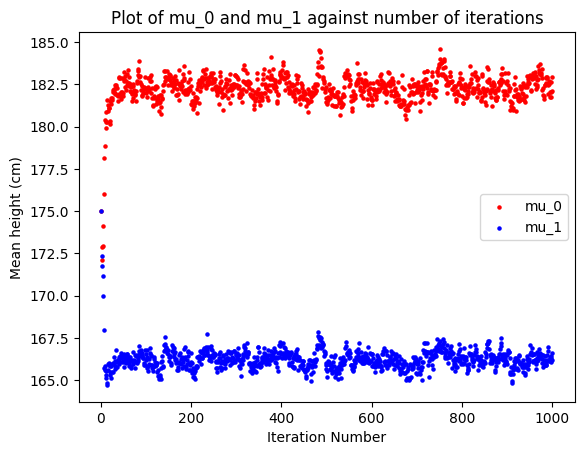

In [ ]:
x = [i for i in range(1, 1002)]
plt.scatter(x, mu_0_list, label="mu_0", c="r", s=5)
plt.scatter(x, mu_1_list, label="mu_1", c="b", s=5)
plt.xlabel("Iteration Number")
plt.ylabel("Mean height (cm)")
plt.title("Plot of mu_0 and mu_1 against number of iterations")
plt.legend()
plt.show()

### Question 1.2 - Plotting the histograms of component heights

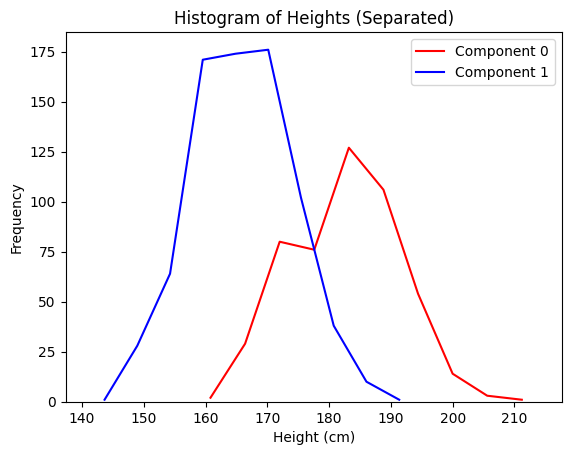

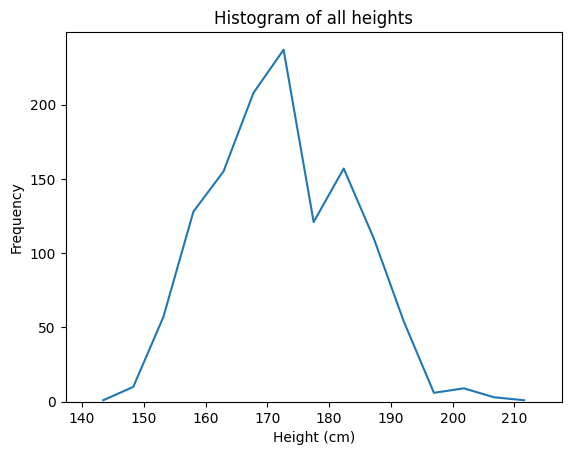

In [ ]:
heights_0 = [heights_list[i] for i in range(n) if z[i] == 0]
heights_1 = [heights_list[i] for i in range(n) if z[i] == 1]

val, bins, _ = plt.hist(
    heights_0, histtype="step", color="b", alpha=0, bins=10
)
bins = [(i + j) / 2 for i, j in zip(bins[:-1], bins[1:])]

m, other_bins, _ = plt.hist(
    heights_1, histtype="step", color="r", alpha=0, bins=10
)
other_bins = [(i + j) / 2 for i, j in zip(other_bins[:-1], other_bins[1:])]

plt.plot(bins, val, color="r", label="Component 0")
plt.plot(other_bins, m, color="b", label="Component 1")
plt.title("Histogram of Heights (Separated)")
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

total, total_bins, _ = plt.hist(
    heights_list, histtype="step", color="b", alpha=0, bins=15
)
total_bins = [(i + j) / 2 for i, j in zip(total_bins[:-1], total_bins[1:])]
plt.plot(total_bins, total)
plt.title("Histogram of all heights")
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")
plt.show()

### Question 1.3 - Plotting the distribution of pi for both components

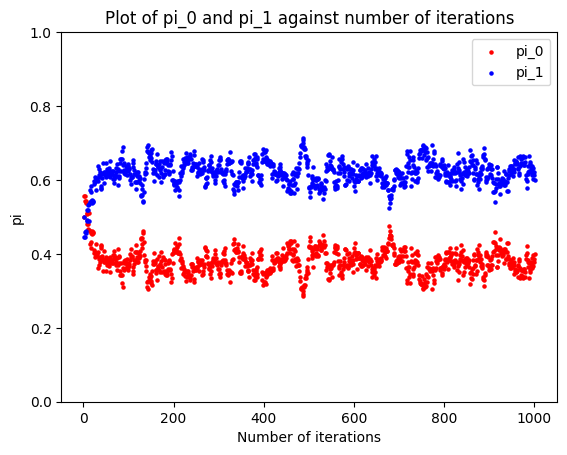

In [ ]:
plt.scatter(x, [1 - i for i in pi_list], label="pi_0", c="r", s=5)
plt.scatter(x, pi_list, label="pi_1", c="b", s=5)
plt.xlabel("Number of iterations")
plt.ylabel("pi")
plt.title("Plot of pi_0 and pi_1 against number of iterations")
plt.ylim(0, 1)
plt.legend()
plt.show()

# Q2: Particle Filter Simulation for Robot Localization

A traveller needs to locate its beloved robot in an unkwown city, but luckly he has a tool that provides the data from the sensors of the robot, but the sensors are not perfect and can provide noisy measurements (the noise information is provided in the code below). Your task is to help the traveller by implementing a Particle Filter algorithm to accurately localize the zone of the robot within the city.


zone = [

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['2', '2', '2', '4', '4', '4', '4', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9']
]

environment = [

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E'],
    
    ['E', 'E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E']
]

In the give environment, 'S' denotes the location of the robot and W denotes walls.




**Transition function**

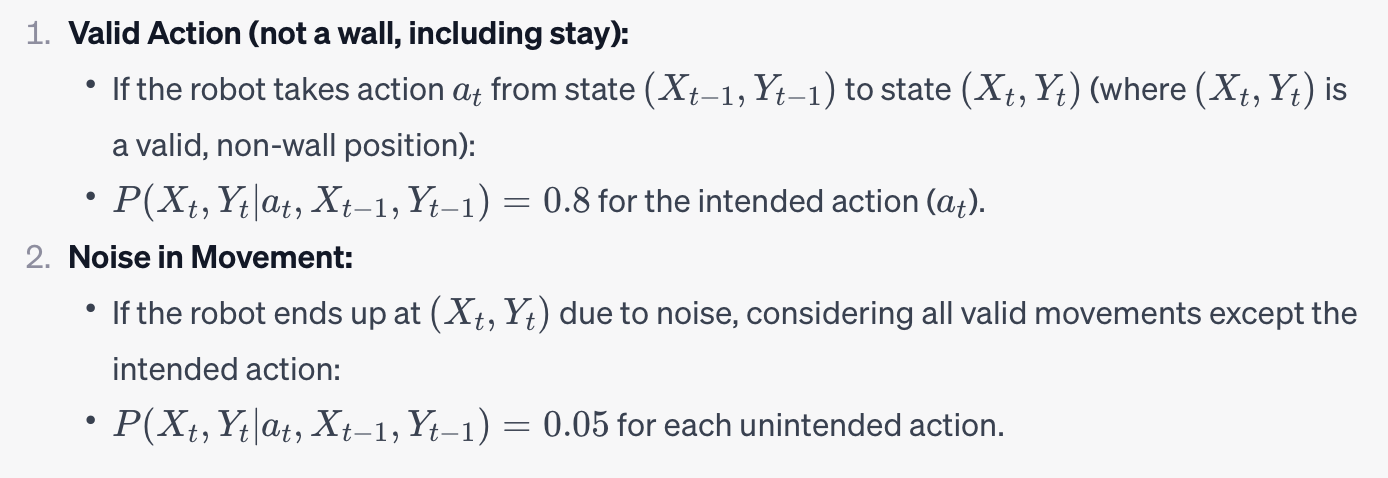

The observation probability P($z_t | x_t, y_t$) represents the probability of the sensor measurement $z_t$ given the true position $x_t, y_t$. The observation probability is 1 indicating that the sensor always detects the true state of the system without any errors, noise, or uncertainty.


**Wrtie a function for the random movement of the robot at each time-step where the action set is {N,S,E,W, stay} where each action is equally likely.**

**[PART 1]** Implement the Particle Filter algorithm (take 5 particles, randomly initialized at empty locations) to localize the robot by estimating its zone after every 10 iterations, till correct zone is located or upto max 100 iterations **[15 marks]**

**Note: Use the 8 neighbouring cells correspoding to the robot and each particle to measure their likehood.**

Example:

Robot (where S denotes the robot)

[E E E]

[W S W]

[E E E]


Particle (where P denotes the particle)

[E E E]

[W P E]

[E E E]

The likelihood of this particle being in the same zone as the robot is 7/8 as their is similarity of 7 neighbouring cells out of 8 based on the sensed infromation.


**[PART 2]** Heatmap: Create a heatmap of the grid where colors represent the probability or weight associated with different cells. Darker colors indicate higher probabilities, providing a visual representation of the confidence in different areas of the grid. **[15 marks]**

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Zones given in the question
zone = [
    ["1", "1", "1", "4", "4", "4", "4", "7", "7", "7"],
    ["1", "1", "1", "4", "4", "4", "4", "7", "7", "7"],
    ["1", "1", "1", "4", "4", "4", "4", "7", "7", "7"],
    ["2", "2", "2", "4", "4", "4", "4", "8", "8", "8"],
    ["2", "2", "2", "5", "5", "5", "5", "8", "8", "8"],
    ["2", "2", "2", "5", "5", "5", "5", "8", "8", "8"],
    ["2", "2", "2", "5", "5", "5", "5", "9", "9", "9"],
    ["3", "3", "3", "6", "6", "6", "6", "9", "9", "9"],
    ["3", "3", "3", "6", "6", "6", "6", "9", "9", "9"],
    ["3", "3", "3", "6", "6", "6", "6", "9", "9", "9"],
]

# The initial environment as given in the question
environment = [
    ["E", "E", "E", "E", "E", "E", "E", "S", "E", "E"],
    ["E", "E", "E", "E", "E", "E", "E", "E", "E", "E"],
    ["E", "E", "E", "E", "E", "E", "E", "E", "E", "E"],
    ["E", "E", "E", "E", "W", "E", "E", "E", "E", "E"],
    ["E", "E", "E", "E", "W", "E", "E", "E", "E", "E"],
    ["E", "E", "E", "E", "E", "W", "W", "E", "E", "E"],
    ["E", "E", "E", "E", "E", "E", "W", "W", "E", "E"],
    ["E", "E", "E", "E", "E", "E", "E", "W", "E", "E"],
    ["E", "E", "E", "E", "E", "E", "E", "E", "W", "E"],
    ["E", "E", "E", "E", "E", "W", "E", "E", "E", "E"],
]

In [ ]:
# All the possible moves that the agent can make and their corresponding weights
moves = [[0, 0], [0, 1], [0, -1], [1, 0], [-1, 0]]
move_weights = [0.2] * 5

In [ ]:
def is_valid_state(state: tuple[int, int], xlim: int, ylim: int) -> bool:
    """
    Function to check if the given state is valid or not i.e. if the state is
    within the grid or not.

    :param state: The state to be checked
    :param xlim: The maximum x-coordinate of the grid
    :param ylim: The maximum y-coordinate of the grid
    :return: True if the state is valid, False otherwise
    """
    return 0 <= state[0] < xlim and 0 <= state[1] < ylim

In [ ]:
def get_next_state(
    current_state: tuple[int, int],
    action: tuple[int, int],
    env: list[list[str]],
) -> tuple[int, int]:
    """
    Function to get the next state given the current state and the action taken
    by the agent. If the next state is not valid or a wall, then the current
    state is returned.

    :param current_state: The current state of the agent
    :param action: The action taken by the agent
    :param env: The environment in which the agent is
    :return: The next state of the agent
    """
    next_state = (current_state[0] + action[0], current_state[1] + action[1])
    if (
        not is_valid_state(next_state, 10, 10)
        or env[next_state[0]][next_state[1]] == "W"
    ):
        next_state = current_state
    return next_state

In [ ]:
def perform_action(
    cur: tuple[int, int], action: tuple[int, int], env: list[list[str]]
) -> tuple[int, int]:
    """
    Function to perform the action given the current state and the action taken
    by the agent. The next state is chosen randomly from the next possible
    states with the corresponding weights.

    :param cur: The current state of the agent
    :param action: The action taken by the agent
    :param env: The environment in which the agent is
    :return: The next state of the agent
    """
    next_states = [get_next_state(cur, action, env)]
    for move in moves:
        if move == action:
            continue
        next_states.append(get_next_state(cur, move, env))
    next_state = random.choices(
        next_states, weights=[0.8, 0.05, 0.05, 0.05, 0.05]
    )[0]
    return next_state

In [ ]:
def get_surroundings(
    location: tuple[int, int], environment: list[list[str]]
) -> list[str]:
    """
    Function to get the surroundings of the given location in the environment.
    If the surrounding is not valid, then the cell is considered an "O". If the
    surrounding is a "S", then it is considered an "E". Otherwise, the cell is
    considered as it is.

    :param location: The location whose surroundings are to be found
    :param environment: The environment in which the agent is
    :return: The surroundings of the given location
    """
    directions = [
        [-1, -1],
        [-1, 0],
        [-1, 1],
        [0, -1],
        [0, 1],
        [1, -1],
        [1, 0],
        [1, 1],
    ]
    surroundings = []
    for dir in directions:
        new_loc = (location[0] + dir[0], location[1] + dir[1])
        if not is_valid_state(new_loc, 10, 10):
            surroundings.append("O")
        elif environment[new_loc[0]][new_loc[1]] == "S":
            surroundings.append("E")
        else:
            surroundings.append(environment[new_loc[0]][new_loc[1]])
    return surroundings

In [ ]:
def weight_and_resample_particles(
    particles: list[tuple[int, int]],
    robot: tuple[int, int],
    environment: list[list[str]],
) -> list[tuple[int, int]]:
    """
    Function to weight the particles based on the similarity between the robot's
    surroundings and the particle's surroundings. The particles are then resampled
    based on the weights. The number of particles is maintained.

    :param particles: The particles to be weighted and resampled
    :param robot: The current location of the robot
    :param environment: The environment in which the agent is
    :return: The weighted and resampled particles
    """
    robot_env = get_surroundings(robot, environment)
    weights = []
    for particle in particles:
        particle_env = get_surroundings(particle, environment)
        similarity = 0
        for idx, cell in enumerate(particle_env):
            if robot_env[idx] == cell:
                similarity += 1
        weights.append(similarity / 8)
    return random.choices(particles, weights, k=len(particles))

In [ ]:
def plot_histogram_from_frequencies(freq: dict[str, int]) -> None:
    """
    Function to plot a histogram from the given frequencies. The frequencies are
    normalized before plotting.

    :param freq: The frequencies to be plotted
    """
    total_freq = sum(freq.values())
    arr = []
    annot = []
    for i in range(1, 4):
        ele = [
            freq[str(i + j)] / total_freq if str(i + j) in freq else 0
            for j in range(0, 7, 3)
        ]
        annot_ele = [f"{ele[j//3]}\n(Zone {i+j})" for j in range(0, 7, 3)]
        arr.append(ele)
        annot.append(annot_ele)
    sns.heatmap(
        arr, annot=annot, fmt="", yticklabels=False, xticklabels=False, cmap="Blues"
    ).set(title="Particle Probability Heatmap")
    plt.show()

In [ ]:
def initialise_particles(
    no_of_particles: int, environment: list[list[str]]
) -> list[tuple[int, int]]:
    """
    Function to initialise the particles randomly in the environment. The number
    of particles is maintained. The particles are not initialised in the walls
    or in the same location.

    :param no_of_particles: The number of particles to be initialised
    :param environment: The environment in which the agent is
    :return: The initialised particles
    """
    particles = []
    for i in range(no_of_particles):
        particle_location = (random.randint(0, 9), random.randint(0, 9))
        while (
            environment[particle_location[0]][particle_location[1]] == "W"
            or particle_location in particles
        ):
            particle_location = (random.randint(0, 9), random.randint(0, 9))
        particles.append(particle_location)
    return particles

In [ ]:
def check_if_robot_found(
    robot_position: tuple[int, int], particles: list[tuple[int, int]], itr: int
) -> bool:
    """
    Function to check if the robot is found in the current iteration. The robot
    is found if the robot's zone is the most frequent zone among the particles.

    :param robot_position: The current location of the robot
    :param particles: The current particles
    :param itr: The current iteration
    :return: True if the robot is found, False otherwise
    """
    robot_zone = zone[robot_position[0]][robot_position[1]]
    particle_zones = [zone[x[0]][x[1]] for x in particles]

    freq = dict()
    for zn in particle_zones:
        if zn not in freq:
            freq[zn] = 1
        else:
            freq[zn] += 1
    largest_freq = max(freq, key=lambda x: freq[x])

    if robot_zone in freq and freq[robot_zone] == freq[largest_freq]:
        print("ROBOT FOUND!")
        print(f"Zone found in iteration {(itr+1)//10 * 10}")
        print("Robot Zone:", robot_zone)
        plot_histogram_from_frequencies(freq)
        return True, freq
    else:
        print(f"Zone not found in iteration {(itr+1)//10 * 10}")
        print("Robot Zone:", robot_zone)
        plot_histogram_from_frequencies(freq)
        print()
    return False, freq

ROBOT FOUND!
Zone found in iteration 10
Robot Zone: 7


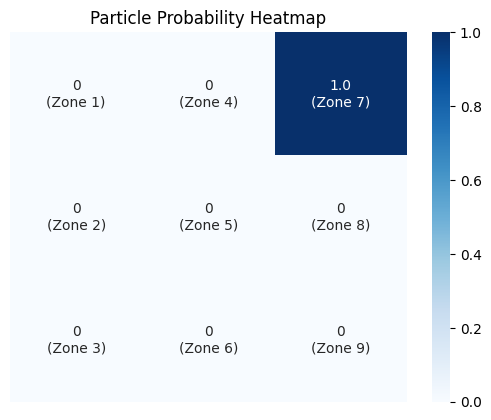

In [ ]:
robot_position = (0, 7)
no_of_particles = 5
particles = initialise_particles(no_of_particles, environment)
is_robot_found = False

for i in range(100):
    robot_action = random.choices(moves, weights=move_weights)[0]
    environment[robot_position[0]][robot_position[1]] = "E"
    robot_position = perform_action(robot_position, robot_action, environment)
    environment[robot_position[0]][robot_position[1]] = "S"

    for idx, particle in enumerate(particles):
        particles[idx] = perform_action(particle, robot_action, environment)
    particles = weight_and_resample_particles(
        particles, robot_position, environment
    )

    if i % 10 == 9:
        is_robot_found, freq = check_if_robot_found(
            robot_position, particles, i
        )
        if is_robot_found:
            break
    robot_position = robot_position

if not is_robot_found:
    print("ROBOT NOT FOUND!")
    print("Robot Zone:", zone[robot_position[0]][robot_position[1]])
    print("Zone not found")
    plot_histogram_from_frequencies(freq)

# Question 3: X-Men MDP

Most of the X-Men are mutants, a subspecies of humans who are born with superhuman abilities activated by the "X-Gene". The X-Men fight for peace and equality between normal humans and mutants in a world where anti-mutant bigotry is fierce and widespread. They are led by Charles Xavier, also known as Professor X, a powerful mutant telepath who can control and read minds. Their archenemy is Magneto, a powerful mutant with the ability to manipulate and control magnetic fields who leads the Brotherhood of Mutants. Both have opposing views and philosophies regarding the relationship between mutants and humans. While the former works towards peace and understanding between mutants and humans, the latter views humans as a threat and believes in taking an aggressive approach against them.

Jean Grey is one of the most beloved X-Men. But when a mission goes wrong, Jean is exposed to a dark and ancient power. This power has destroyed everything it comes in contact with, until her. Now that this power is becoming unstable, she releases it with destruction and anger. Now that this foreign power is consuming her, and the world is threatened, the X-Men have to face an important truth: they must save either the world, or their friend who threatens it. Magneto calls her ‘The phoenix’ and intends to use her to declare war against humanity.

In this question, you will use some algorithms to compute optimal policies in Markov decision processes (MDP’s) to help wolverine escape from Magneto while trying to find Jean in order to kill her.

You are given the following grid world where Wolverine and other mutants from Xavier's School for Gifted Youngsters live along with Magneto and his brotherhood of mutants.




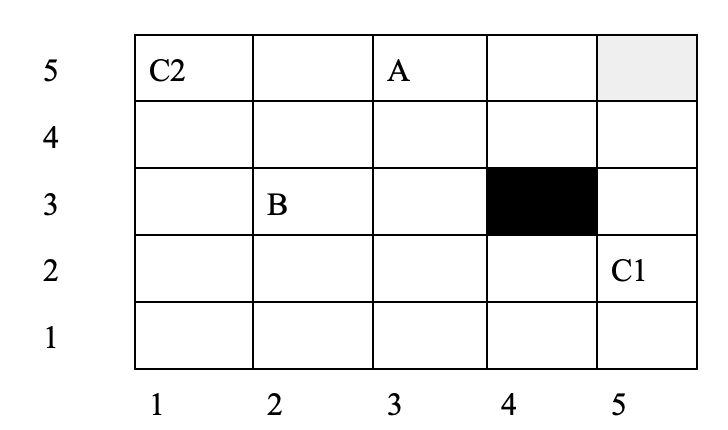

The wolverine (A) can occupy any of the 24 blank squares. The Magneto (B) also can occupy any square, except for square (5,5) which is Xavier’s school of Gifted Youngsters. Jean which can be at C1(5,2) or C2(1,5). Currently, she is at (5,2). Thus, MDP has 24*23*2 = 1104 states.

Wolverine and Magneto can each move one square in any direction - Up,down,left and right but not diagonal. They also can choose not to move at all. (4,3) is blocked due to the wall. Thus, there are 5 possible moves from each square. If an action is attempted that causes the characters(Wolverine and Magneto) to bump into a wall, then simply stay at the same location. In this problem, we will always take the point of view of the wolverine.

Reward Policies:

When Wolverine is at Jean’s place, it receives a reward of +20.
When Magneto is at Wolverine’s place, Wolverine receives a reward of -20.
When the Magneto is at wolverine’s place and wolverine is at jean’s place, the reward is -15.

All other configurations have a reward of 0.
Thus, the wolverine is trying to kill Jean while simultaneously avoiding the Magneto.

Jean is always available in exactly one of the two locations listed above. At every time step, Jean remains where she is with 80% probability. With 20% probability, Jean vanishes and reappears at another location.

States are encoded as six tuples, the first two numbers indicating the position of Magneto, the second two numbers the position of Wolverine, and the last two numbers the position of Jean. Thus, 2:3:3:5:5:2 indicates, as depicted in the figure above, that Magneto is in (2,3), Wolverine is in (3,5), and Jean is in (5,2). Magneto and wolverine take alternate moves. However, in encoding the MDP, we collapse both moves into a single state transition. In addition, Jean, when she moves, does so simultaneously with the wolverine's move. For instance, from the configuration above, if the wolverine moves to (2,5) and the Magneto responds by moving to (2,4), while jean moves to (1,5), this all would be encoded as a single transition from state 2:3:3:5:5:2 to 2:4:2:5:1:5.

The Wolverine and Magneto have 4 actions available ('UP', 'RIGHT', 'DOWN' and 'LEFT'). Each action moves the Wolverine/Magneto in its direction with probability 0.95. When the wolverine tries to move outside of the grid, the action will have no effect with probability 1. Staying in its own state will happen with probability 0.05.

We will consider two versions of Magneto:

In first version, Magneto is dumb and lazy, simply wanders randomly around its environment choosing randomly among its available actions at every step.
In the second version, Magneto is intelligent and active. Here, Magneto always heads straight for wolverine following the shortest path possible. Thus, after wolverine makes its move, Magneto chooses the action that will move it as close as possible to the wolverine's new position. (If there is a tie among the Magneto's best available options, the Magneto chooses randomly among these equally good best actions.)
    
For both versions of Magneto, your job will be to compute the wolverine's optimal policy, i.e. the action that should be taken at each state to maximize the wolverine's expected discounted reward, where we fix the discount factor (gamma) to be 0.85.

**Task 1:** Implement value iteration for both versions of Magneto on MDP [10 points]

**Task 2:** Implement policy iteration for both versions of Magneto [10 points]

**Task 3:** Implement and visualize the MDP board and strategy (policy) graphically [10 points]

**Task 4:** Compare the results for all the four approaches - Value iteration for lazy Magneto, Value iteration for active Magneto, Policy iteration for lazy Magneto, Policy iteration for active Magneto with proper tables/graphs/statistics. Comment which one is best among all the four mentioned approaches. [10 points]



In [ ]:
from copy import deepcopy
import random
import itertools
import matplotlib.pyplot as plt

In [ ]:
# The starting state of the environment as given in the question
starting_state = [
    ["X", "X", "W", "X", "S"],
    ["X", "X", "X", "X", "X"],
    ["X", "M", "X", "-", "X"],
    ["X", "X", "X", "X", "J"],
    ["X", "X", "X", "X", "X"],
]

In [ ]:
class State:
    """
    Class to store the state of the environment. The state consists of the
    the current locations of magneto, wolverine and jean.

    :ivar m: The current location of magneto
    :ivar w: The current location of wolverine
    :ivar j: The current location of jean
    """

    m: tuple[int, int]
    w: tuple[int, int]
    j: tuple[int, int]

    def __init__(
        self, m: tuple[int, int], w: tuple[int, int], j: tuple[int, int]
    ) -> None:
        self.m = m
        self.w = w
        self.j = j

    def __iter__(self):
        return iter((self.m, self.w, self.j))

    def __str__(self) -> str:
        return f"m: {self.m}, w: {self.w}, j: {self.j}"

    def __repr__(self) -> str:
        return f"m: {self.m}, w: {self.w}, j: {self.j}"

    def __eq__(self, o: 'State') -> bool:
        return self.m == o.m and self.w == o.w and self.j == o.j

    def __hash__(self) -> int:
        return hash((self.m, self.w, self.j))

In [ ]:
class MDP:
    """
    Class to store the Markov Decision Process. The class stores the states,
    the actions, the transition probabilities and the rewards. The class also
    stores the utility and the policy. The class is modified for the given
    environment and also stores the location of the school and the wall.

    :ivar states: The states of the MDP
    :ivar gamma: The discount factor
    :ivar actions: The actions of the MDP
    :ivar jean_positions: The possible locations of jean
    :ivar wall: The location of the wall
    :ivar school: The location of the school
    :ivar state_index_list: The dictionary to store the indices of the states
    :ivar xlim: The maximum x-coordinate of the grid + 1
    :ivar ylim: The maximum y-coordinate of the grid + 1
    """

    states: tuple[State]
    gamma: float
    actions: tuple[tuple[int, int]]
    jean_positions: tuple[tuple[int, int]]
    wall: tuple[int, int]
    school: tuple[int, int]
    state_index_list: dict[State, int]
    xlim: int
    ylim: int

    def __init__(
        self,
        jean_positions=((0, 0), (3, 4)),
        actions=((0, 1), (1, 0), (0, -1), (-1, 0)),
        gamma=0.85,
        wall=(2, 3),
        school=(0, 4),
        xlim=5,
        ylim=5,
    ) -> None:
        self.actions = actions
        self.jean_positions = jean_positions
        self.gamma = gamma
        self.wall = wall
        self.school = school
        self.xlim = xlim
        self.ylim = ylim
        self.state_index_list = dict()
        self.states = self.get_ordered_states()

    def get_ordered_states(self) -> tuple[State]:
        """
        Function to get the ordered states of the MDP. The ordered states are
        the states where the locations of magneto, wolverine and jean are
        different. The ordered states are stored in the state_index_list which
        is a dictionary that maps the states to their indices.

        :return: The ordered states of the MDP
        """
        cells = [(i, j) for i in range(self.xlim) for j in range(self.ylim)]
        cells.remove(self.wall)
        states = []
        idx = 0
        for pair in itertools.product(cells, repeat=2):
            m, w = pair
            if m == self.school:
                continue
            states.append(State(m, w, (0, 0)))
            self.state_index_list[State(m, w, (0, 0))] = idx
            idx += 1
            states.append(State(m, w, (3, 4)))
            self.state_index_list[State(m, w, (3, 4))] = idx
            idx += 1
        return states

    def get_initial_utilities(
        self,
    ) -> tuple[dict[State, int], dict[State, int]]:
        """
        Function to get the initial utilities of the states. The initial
        utilities are 0 for all the states except the states where magneto,
        wolverine and jean are in the same cell. The initial utilities for those
        states are as given in the question.

        :return: The initial utilities of the states
        """
        utility = dict()
        actions = dict()
        for state in self.states:
            m, w, j = state
            if w == m and w == j:
                utility[state] = -15
            elif w == m:
                utility[state] = -20
            elif w == j:
                utility[state] = 20
            else:
                utility[state] = 0
            actions[state] = [0, -1]
        return utility, actions

    def get_next_state(
        self,
        current_state: tuple[int, int],
        action: tuple[int, int],
        magneto: bool = False,
    ) -> tuple[int, int]:
        """
        Function to get the next state given the current state and the action
        taken by the agent. If the next state is not valid or a wall, then the
        current state is returned.

        :param current_state: The current state of the agent
        :param action: The action taken by the agent
        :param magneto: True if the agent is magneto, False otherwise
        :return: The next state of the agent
        """
        next_state = (
            current_state[0] + action[0],
            current_state[1] + action[1],
        )
        if (
            not self.is_valid_state(*next_state)
            or next_state == self.wall
            or (magneto and next_state == self.school)
        ):
            next_state = current_state
        return next_state

    def is_valid_state(self, row: int, col: int) -> bool:
        """
        Function to check if the given state is valid or not i.e. if the state
        is within the grid or not.

        :param row: The row of the state
        :param col: The column of the state
        :return: True if the state is valid, False otherwise
        """
        return 0 <= row < self.xlim and 0 <= col < self.ylim

In [ ]:
def perform_jean_action(jean: tuple[int, int], mdp: MDP) -> tuple[int, int]:
    """
    Function to perform the action taken by jean. The action taken by jean is
    chosen randomly from the possible actions with the corresponding weights.

    :param jean: The current location of jean
    :param mdp: The MDP in which jean is
    :return: The next location of jean
    """
    jean_positions = mdp.jean_positions
    weights = [
        0.8 if jean == jean_positions[0] else 0.2,
        0.2 if jean == jean_positions[0] else 0.8,
    ]
    return random.choices(jean_positions, weights)[0]

In [ ]:
def magneto_random_move(magneto: tuple[int, int], mdp: MDP) -> tuple[int, int]:
    """
    Function to perform the random move of magneto. The next state is chosen
    randomly from the next possible states with the corresponding weights.

    :param magneto: The current location of magneto
    :param mdp: The MDP in which magneto is
    :return: The next location of magneto
    """
    moves = set()
    for action in mdp.actions:
        new_state = mdp.get_next_state(magneto, action, magneto=True)
        moves.add(new_state)
    return random.choice([*moves])


def magneto_perfect_move(
    magneto: tuple[int, int], wolverine: tuple[int, int], mdp: MDP
) -> tuple[int, int]:
    """
    Function to perform the perfect move of magneto. The next state is chosen
    such that the distance between magneto and wolverine is minimum.

    :param magneto: The current location of magneto
    :param wolverine: The current location of wolverine
    :param mdp: The MDP in which magneto is
    :return: The next location of magneto
    """
    moves = dict()
    for action in mdp.actions:
        new_state = mdp.get_next_state(magneto, action, magneto=True)
        dist = abs(new_state[0] - wolverine[0]) + abs(
            new_state[1] - wolverine[1]
        )
        if dist not in moves:
            moves[dist] = set()
        moves[dist].add(new_state)
    min_dist = min(list(moves))
    return random.choice([*(moves[min_dist])])


def get_magneto_best_moves(
    magneto: tuple[int, int], wolverine: tuple[int, int], mdp: MDP
) -> tuple[tuple[int, int]]:
    """
    Function to get the best moves of magneto. The best moves are the moves
    which are the closest to wolverine.

    :param magneto: The current location of magneto
    :param wolverine: The current location of wolverine
    :param mdp: The MDP in which magneto is
    :return: The best moves of magneto
    """
    moves = dict()
    for action in mdp.actions:
        new_state = mdp.get_next_state(magneto, action, magneto=True)
        dist = abs(new_state[0] - wolverine[0]) + abs(
            new_state[1] - wolverine[1]
        )
        if dist not in moves:
            moves[dist] = set()
        moves[dist].add(action)
    min_dist = min(list(moves))
    return tuple([*(moves[min_dist])])

## Value Iteration

In [ ]:
def get_next_states(
    current_state: tuple[int, int],
    mdp: MDP,
    wolverine_action: tuple[int, int],
    magneto_actions: tuple[tuple[int, int]],
) -> tuple[tuple[State], tuple[float]]:
    """
    Function to get the next states given the current state, the MDP, the action
    taken by wolverine and the possible actions of magneto. The next states are
    chosen randomly from the next possible states with the corresponding weights.
    For each next state, the probability of that state is also calculated. The
    probability of the next state is the product of the probability of the action
    taken by wolverine and the probability of the action taken by magneto.

    :param current_state: The current state of the agent
    :param mdp: The MDP in which the agent is
    :param wolverine_action: The action taken by wolverine
    :param magneto_actions: The possible actions of magneto
    :return: The next states and their corresponding probabilities
    """
    magneto_prob = 1 / len(magneto_actions)
    next_states = []
    state_prob = []
    for action in magneto_actions:
        for jean_next in mdp.jean_positions:
            jean_prob = 0.8 if jean_next == current_state.j else 0.2
            next_states.append(
                State(
                    mdp.get_next_state(current_state.m, action, True),
                    mdp.get_next_state(current_state.w, wolverine_action),
                    jean_next,
                )
            )
            state_prob.append(magneto_prob * 0.95 * 0.95 * jean_prob)
            next_states.append(
                State(
                    mdp.get_next_state(current_state.m, action, True),
                    current_state.w,
                    jean_next,
                )
            )
            state_prob.append(magneto_prob * 0.95 * 0.05 * jean_prob)
    for jean_next in mdp.jean_positions:
        jean_prob = 0.8 if jean_next == current_state.j else 0.2
        next_states.append(
            State(
                current_state.m,
                mdp.get_next_state(current_state.w, wolverine_action),
                jean_next,
            )
        )
        state_prob.append(0.05 * 0.95 * jean_prob)
        next_states.append(
            State(
                current_state.m,
                current_state.w,
                jean_next,
            )
        )
        state_prob.append(0.05 * 0.05 * jean_prob)
    return next_states, state_prob


def get_best_action(
    utility: dict[State, float],
    current_state: State,
    mdp: MDP,
    magneto_random: bool = True,
) -> tuple[float, tuple[int, int]]:
    """
    Function to get the best action given the current state, the MDP and the
    utility of the states. The best action is the action which maximises the
    expected utility of the next state.

    :param utility: The utility of the states
    :param current_state: The current state of the agent
    :param mdp: The MDP in which the agent is
    :param magneto_random: True if magneto is random, False otherwise
    :return: The best action and the expected utility of the next state
    """
    max_reward = float("-inf")
    max_action = None
    if magneto_random:
        for wolverine_action in mdp.actions:
            next_states, state_probs = get_next_states(
                current_state, mdp, wolverine_action, mdp.actions
            )
            reward = 0
            for idx, next_state in enumerate(next_states):
                reward += state_probs[idx] * utility[next_state] * mdp.gamma
            if reward > max_reward:
                max_reward = reward
                max_action = wolverine_action
    else:
        for wolverine_action in mdp.actions:
            wolverine_next_state = mdp.get_next_state(
                current_state.w, wolverine_action
            )
            magneto_moves = get_magneto_best_moves(
                current_state.m, wolverine_next_state, mdp
            )
            next_states, state_probs = get_next_states(
                current_state, mdp, wolverine_action, magneto_moves
            )
            reward = 0
            for idx, next_state in enumerate(next_states):
                reward += state_probs[idx] * utility[next_state] * mdp.gamma
            if reward > max_reward:
                max_reward = reward
                max_action = wolverine_action
    return max_reward, max_action

In [ ]:
def value_iteration(
    mdp: MDP, limit: float, magneto_random: float = True
) -> tuple[dict[State, float], dict[State, tuple[int, int]]]:
    """
    Function to perform the value iteration algorithm on the given MDP. The
    value iteration algorithm is performed until the difference between the
    utilities of the states in two consecutive iterations is less than the
    given limit.

    :param mdp: The MDP on which the value iteration algorithm is to be performed
    :param limit: The limit on the difference between the utilities of the states
    :param magneto_random: True if magneto is random, False otherwise
    :return: The utilities of the states and the policy
    """
    current_utilities, current_actions = mdp.get_initial_utilities()
    gamma = mdp.gamma
    value_iteration.utility = [sum(current_utilities.values())/1104]
    value_iteration.itr = 0
    value_iteration.last_itr = 1
    itr = 1

    while True:
        new_utilities = dict()
        new_actions = dict()
        delta = 0

        for state in mdp.states:
            m, w, j = state
            if w == m or w == j:
                new_utilities[state] = current_utilities[state]
                new_actions[state] = current_actions[state]
                continue
            max_utility, max_action = get_best_action(
                current_utilities, state, mdp, magneto_random
            )
            new_utilities[state] = max_utility
            new_actions[state] = max_action
            delta = max(delta, abs(max_utility - current_utilities[state]))

        if current_actions != new_actions:
            value_iteration.itr += 1
            value_iteration.last_itr = itr
        itr += 1
        current_utilities = new_utilities
        current_actions = new_actions
        value_iteration.utility.append(sum(current_utilities.values())/1104)
        if delta < limit * (1 - gamma) / gamma:
            break

    return current_utilities, current_actions

## Playing the Game Graphically (Value Iteration)

In [ ]:
def update_board(
    board, old_magneto, old_wolverine, old_jean, magneto, wolverine, jean
):
    board[old_magneto[0]][old_magneto[1]] = "X"
    board[old_wolverine[0]][old_wolverine[1]] = "X"
    board[old_jean[0]][old_jean[1]] = "X"
    board[0][4] = 'S'
    board[magneto[0]][magneto[1]] = "M"
    board[jean[0]][jean[1]] = "J"
    board[wolverine[0]][wolverine[1]] = "W"
    return board

def pretty_print_board(board):
    print("-"*21)
    for row in board:
        print("| ", end='')
        for cell in row:
            print(cell, end=" | ")
        print()
        print("-"*21)
    print()

def convert_coordinates(x, y, xlim, ylim):
    return ylim-y, x-1

In [ ]:
def play_game(
    board, actions, magneto, wolverine, jean, mdp: MDP, is_magneto_intelligent
):
    i = 1
    while True:
        wolverine_action = actions[State(magneto, wolverine, jean)]
        new_wolverine = mdp.get_next_state(wolverine, wolverine_action)
        if random.random() > 0.95:
            new_wolverine = wolverine
        if not is_magneto_intelligent:
            new_magneto = magneto_random_move(magneto, mdp)
        else:
            new_magneto = magneto_perfect_move(magneto, new_wolverine, mdp)
        if random.random() > 0.95:
            new_magneto = magneto
        new_jean = perform_jean_action(jean, mdp)
        board = update_board(
            board,
            magneto,
            wolverine,
            jean,
            new_magneto,
            new_wolverine,
            new_jean,
        )
        print(f"Move {i}:")
        pretty_print_board(board)
        if new_wolverine == new_jean and new_wolverine == new_magneto:
            print("Magneto caught Wolverine and Jean. Reward = -15")
            break
        elif new_wolverine == new_jean:
            print("Wolverine found Jean. Reward = 20")
            break
        elif new_wolverine == new_magneto:
            print("Magneto caught Wolverine. Reward = -20")
            break
        i += 1
        magneto = new_magneto
        wolverine = new_wolverine
        jean = new_jean

In [ ]:
print("Notation in the Diagram")
print("X: Empty Space")
print("W: Wolverine")
print("M: Magneto")
print("S: School")
print("J: Jean")
print("-: Wall")

Notation in the Diagram
X: Empty Space
W: Wolverine
M: Magneto
S: School
J: Jean
-: Wall


In [ ]:
# Value Iteration for dumb and lazy Magneto
game = MDP()
utility, actions = value_iteration(game, 0.000001)

# You can use convert_coordinates(x, y, 5, 5) if you wish to use the coordinates
# as in the diagram i.e. j = convert_coordinates(5, 2, 5, 5) and so on

j = (3, 4)
m = (2, 1)
w = (0, 2)
board = deepcopy(starting_state)

play_game(board, actions, m, w, j, game, magneto_random_move)

Move 1:
---------------------
| X | W | X | X | S | 
---------------------
| X | M | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 2:
---------------------
| W | X | X | X | S | 
---------------------
| M | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | X | 
---------------------
| X | X | X | X | X | 
---------------------

Wolverine found Jean. Reward = 20


In [ ]:
# Value Iteration for intelligent and active Magneto
game = MDP()
utility, actions = value_iteration(game, 0.000001, magneto_random=False)

# You can use convert_coordinates(x, y, 5, 5) if you wish to use the coordinates
# as in the diagram i.e. j = convert_coordinates(5, 2, 5, 5) and so on

j = (3, 4)
m = (2, 1)
w = (0, 2)
board = deepcopy(starting_state)

play_game(board, actions, m, w, j, game, True)

Move 1:
---------------------
| X | W | X | X | S | 
---------------------
| X | M | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 2:
---------------------
| W | M | X | X | S | 
---------------------
| X | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 3:
---------------------
| M | X | X | X | S | 
---------------------
| W | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 4:
---------------------
| J | X | X | X | S | 
---------------------
| X | W | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | X | 
---------------------
| X | X | X | X | X | 

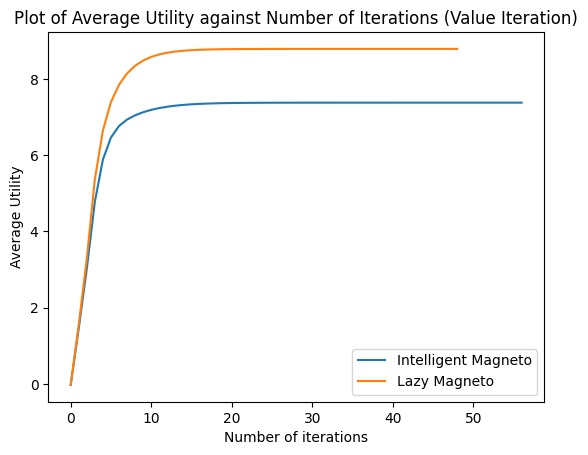

In [ ]:
game = MDP()

value_iteration(game, 0.000001, magneto_random=False)
utilities = value_iteration.utility

value_iteration(game, 0.000001, magneto_random=True)
utilities_random = value_iteration.utility

plt.plot([i for i in range(0, len(utilities))], utilities, label="Intelligent Magneto")
plt.plot([i for i in range(0, len(utilities_random))], utilities_random, label="Lazy Magneto")
plt.xlabel("Number of iterations")
plt.ylabel("Average Utility")
plt.title("Plot of Average Utility against Number of Iterations (Value Iteration)")
plt.legend()
plt.show()

In [ ]:
# Comparing the time taken for the two algorithms
import time

game = MDP()
start = time.time()
value_iteration(game, 0.000001, magneto_random=False)
end = time.time()
print(f"Time taken for intelligent magneto (Value iteration): {end-start}")

start = time.time()
value_iteration(game, 0.000001, magneto_random=True)
end = time.time()
print(f"Time taken for lazy magneto (Value iteration): {end-start}")

Time taken for intelligent magneto (Value iteration): 8.952445030212402
Time taken for lazy magneto (Value iteration): 11.030631065368652


## Policy Iteration

In [ ]:
def get_initial_policy(mdp: MDP) -> dict[State, tuple[int, int]]:
    """
    Function to get the initial policy of the MDP. The initial policy is just a
    random policy.

    :param mdp: The MDP for which the initial policy is to be found
    :return: The initial policy of the MDP
    """
    states = mdp.states
    actions = mdp.actions
    policy = dict()
    for state in states:
        policy[state] = random.choice(actions)
    return policy

In [ ]:
import numpy as np


def policy_evaluation(
    mdp: MDP,
    policy: dict[State, tuple[int, int]],
    utilities: dict[State, float],
    magneto_random: bool = True,
) -> dict[State, float]:
    """
    Function to perform the policy evaluation algorithm on the given MDP. The
    utility of each state is calculated using the given policy. The utility of
    the states is calculated by solving the linear equations.

    :param mdp: The MDP on which the policy evaluation algorithm is to be performed
    :param policy: The policy to be evaluated
    :param utilities: The utilities of the states
    :param magneto_random: True if magneto is random, False otherwise
    :return: The utilities of the states
    """
    a = [0] * 1104
    b = [0] * 1104
    for state in mdp.states:
        eqn = [0] * 1104
        if state.m == state.w or state.w == state.j:
            idx = mdp.state_index_list[state]
            eqn[idx] = 1
            b[idx] = utilities[state]
            a[idx] = eqn
            continue
        action = policy[state]
        eqn[mdp.state_index_list[state]] = 1
        if magneto_random:
            next_states, state_probs = get_next_states(
                state, mdp, action, mdp.actions
            )
        else:
            wolverine_next = mdp.get_next_state(state.w, action)
            magneto_moves = get_magneto_best_moves(state.m, wolverine_next, mdp)
            next_states, state_probs = get_next_states(
                state, mdp, action, magneto_moves
            )
        for idx, next_state in enumerate(next_states):
            eqn[mdp.state_index_list[next_state]] -= (
                state_probs[idx] * mdp.gamma
            )
        idx = mdp.state_index_list[state]
        a[idx] = eqn
    solution = np.linalg.solve(a, b)
    utility = dict()
    for idx, state in enumerate(mdp.states):
        utility[state] = solution[idx]
    return utility

In [ ]:
def policy_iteration(
    mdp: MDP, magneto_random: bool = True
) -> dict[State, tuple[int, int]]:
    """
    Function to perform the policy iteration algorithm on the given MDP. The
    policy iteration algorithm is performed until the policy is unchanged in
    two consecutive iterations.

    :param mdp: The MDP on which the policy iteration algorithm is to be performed
    :param magneto_random: True if magneto is random, False otherwise
    :return: The policy of the states
    """
    initial_utilities, _ = mdp.get_initial_utilities()
    current_policy = get_initial_policy(mdp)
    policy_iteration.utilities = [sum(initial_utilities.values())/1104]

    while True:
        current_utilities = policy_evaluation(
            mdp, current_policy, initial_utilities, magneto_random
        )
        policy_iteration.utilities.append(sum(current_utilities.values())/1104)
        unchanged = True
        for state in mdp.states:
            if state.m == state.w or state.w == state.j:
                continue
            max_utility, max_action = get_best_action(
                current_utilities, state, mdp, magneto_random
            )
            # Just to ensure no infinite loops due to comparing two floating
            # point numbers, an accuracy of 1e-6 is used
            if max_utility - current_utilities[state] > 0.000001:
                current_policy[state] = max_action
                unchanged = False
        if unchanged:
            break
    return current_policy

## Playing the Game Graphically (Policy Iteration)

In [ ]:
# Policy Iteration for dumb and lazy Magneto

game = MDP()
policy = policy_iteration(game, magneto_random=True)

# You can use convert_coordinates(x, y, 5, 5) if you wish to use the coordinates
# as in the diagram i.e. j = convert_coordinates(5, 2, 5, 5) and so on

j = (3, 4)
m = (2, 1)
w = (0, 2)
board = deepcopy(starting_state)

play_game(board, policy, m, w, j, game, True)

Move 1:
---------------------
| X | W | X | X | S | 
---------------------
| X | M | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 2:
---------------------
| W | X | X | X | S | 
---------------------
| M | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 3:
---------------------
| X | W | X | X | S | 
---------------------
| X | M | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 4:
---------------------
| W | X | X | X | S | 
---------------------
| M | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 

In [ ]:
# Policy Iteration for intelligent and active Magneto

game = MDP()
policy = policy_iteration(game, magneto_random=False)

# You can use convert_coordinates(x, y, 5, 5) if you wish to use the coordinates
# as in the diagram i.e. j = convert_coordinates(5, 2, 5, 5) and so on

j = (3, 4)
m = (2, 1)
w = (0, 2)
board = deepcopy(starting_state)

play_game(board, policy, m, w, j, game, True)

Move 1:
---------------------
| X | W | X | X | S | 
---------------------
| X | M | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | J | 
---------------------
| X | X | X | X | X | 
---------------------

Move 2:
---------------------
| W | M | X | X | S | 
---------------------
| X | X | X | X | X | 
---------------------
| X | X | X | - | X | 
---------------------
| X | X | X | X | X | 
---------------------
| X | X | X | X | X | 
---------------------

Wolverine found Jean. Reward = 20


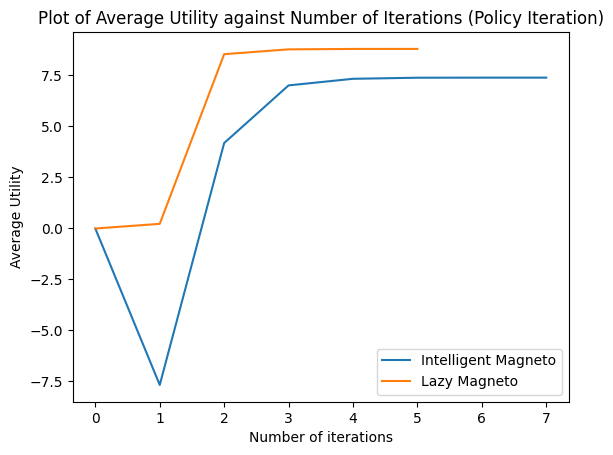

In [ ]:
game = MDP()

policy_iteration(game, magneto_random=False)
utilities = policy_iteration.utilities

policy_iteration(game, magneto_random=True)
utilities_random = policy_iteration.utilities

plt.plot([i for i in range(0, len(utilities))], utilities, label="Intelligent Magneto")
plt.plot([i for i in range(0, len(utilities_random))], utilities_random, label="Lazy Magneto")
plt.xlabel("Number of iterations")
plt.ylabel("Average Utility")
plt.title("Plot of Average Utility against Number of Iterations (Policy Iteration)")
plt.legend()
plt.show()

In [ ]:
# Comparing the time taken for the two algorithms
import time

game = MDP()
start = time.time()
policy_iteration(game, magneto_random=False)
end = time.time()
print(f"Time taken for intelligent magneto (Policy iteration): {end-start}")

start = time.time()
policy_iteration(game, magneto_random=True)
end = time.time()
print(f"Time taken for lazy magneto (Policy iteration): {end-start}")

Time taken for intelligent magneto (Policy iteration): 2.381267786026001
Time taken for lazy magneto (Policy iteration): 2.9267914295196533


### Comparing Policy and Value Iteration

Time taken for value iteration (intelligent magneto): 9.27888035774231
Time taken for policy iteration (intelligent magneto): 2.4062869548797607
Time taken for value iteration (lazy magneto): 11.059056043624878
Time taken for policy iteration (lazy magneto): 3.265861988067627

Number of iterations for policy to converge in value iteration (intelligent magneto): 55 vs total iterations of 56
Number of iterations for policy to converge in value iteration (lazy magneto): 18 vs total iterations of 48

Number of policy changes in value iteration (intelligent magneto): 32
Number of policy changes in value iteration (lazy magneto): 14
Number of iterations in policy iteration (intelligent magneto): 6
Number of iterations in policy iteration (lazy magneto): 5



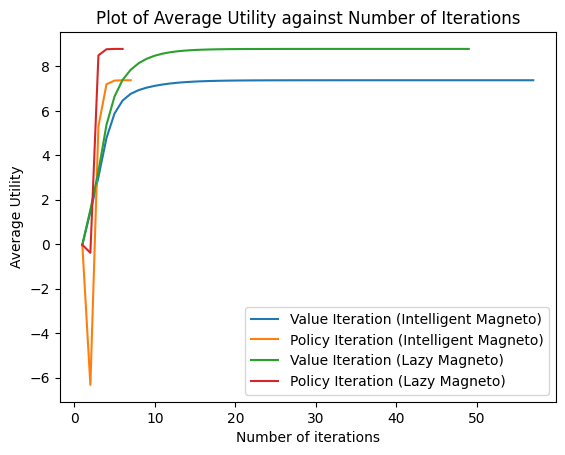

In [ ]:
# Comparing the two algorithms based on utility and time taken
import time

game = MDP()

start = time.time()
value_iteration(game, 0.000001, magneto_random=False)
value_time = time.time() - start
value_policy_convergence_time = value_iteration.last_itr
policy_changes = value_iteration.itr
utilities_value = value_iteration.utility

start = time.time()
policy_iteration(game, magneto_random=False)
policy_time = time.time() - start
utilities_policy = policy_iteration.utilities

start = time.time()
value_iteration(game, 0.000001, magneto_random=True)
value_random_time = time.time() - start
value_random_policy_convergence_time = value_iteration.last_itr
policy_random_changes = value_iteration.itr
utilities_value_random = value_iteration.utility

start = time.time()
policy_iteration(game, magneto_random=True)
policy_random_time = time.time() - start
utilities_policy_random = policy_iteration.utilities

print(f"Time taken for value iteration (intelligent magneto): {value_time}")
print(f"Time taken for policy iteration (intelligent magneto): {policy_time}")
print(f"Time taken for value iteration (lazy magneto): {value_random_time}")
print(f"Time taken for policy iteration (lazy magneto): {policy_random_time}")
print()

print(f"Number of iterations for policy to converge in value iteration (intelligent magneto): {value_policy_convergence_time} vs total iterations of {len(utilities_value)-1}")
print(f"Number of iterations for policy to converge in value iteration (lazy magneto): {value_random_policy_convergence_time} vs total iterations of {len(utilities_value_random)-1}")
print()

print(f"Number of policy changes in value iteration (intelligent magneto): {policy_changes}")
print(f"Number of policy changes in value iteration (lazy magneto): {policy_random_changes}")
print(f"Number of iterations in policy iteration (intelligent magneto): {len(utilities_policy)-1}")
print(f"Number of iterations in policy iteration (lazy magneto): {len(utilities_policy_random)-1}")
print()

plt.plot([i for i in range(1, len(utilities_value)+1)], utilities_value, label="Value Iteration (Intelligent Magneto)")
plt.plot([i for i in range(1, len(utilities_policy)+1)], utilities_policy, label="Policy Iteration (Intelligent Magneto)")
plt.plot([i for i in range(1, len(utilities_value_random)+1)], utilities_value_random, label="Value Iteration (Lazy Magneto)")
plt.plot([i for i in range(1, len(utilities_policy_random)+1)], utilities_policy_random, label="Policy Iteration (Lazy Magneto)")
plt.xlabel("Number of iterations")
plt.ylabel("Average Utility")
plt.title("Plot of Average Utility against Number of Iterations")
plt.legend()
plt.show()

### Comparison

From the above data it is clear that policy iteration takes fewer iterations to converge than value iteration for both versions of magneto. Policy iteration also takes lesser time to converge than value iteration for the same accuracy. This may be due to the fact that even if the policy converges in value iteration, it cannot terminate until the values converge. The value space is also larger than the policy space (when each state contains a fixed number of actions) which may also be a contributing factor to policy iteration converging faster than value iteration. Hence policy iteration appears to be a better approach than value iteration in finding the optimal policy.

Both value and policy iteration converge faster for the intelligent version of magneto because there are lesser actions that magneto can take at each location and hence fewer calculations. The time and the number of iterations taken for policy iteration however does seem to depend on what initial policy is available.